In [1]:
from __future__ import print_function
import pandas as pd
import matplotlib.pyplot as plt
import http.client
import json
import csv
import os
from textblob import TextBlob
import numpy as np
import time
import gc
import random
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_validate, train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from datetime import datetime, timedelta
import tensorflow as tf
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.utils import pad_sequences
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.datasets import imdb
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
import shap
import spacy
import re
from dateutil import tz
from pytz import timezone
import pytz

2023-02-13 20:43:29.235671: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/jonhuaqin/opt/anaconda3/envs/tensyflow/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
nlp = spacy.load('en_core_web_sm')

In [3]:
def timeconvert(utc):
    from_zone = tz.gettz('UTC')
    to_zone = tz.gettz('America/New_York')
    utc = utc.replace(tzinfo=from_zone)
    est = utc.astimezone(to_zone)
    return est

In [4]:
comment_work1 = pd.read_json("/Users/jonhuaqin/Helen/CODE/comments2021_work.txt")
comment_work2 = pd.read_json("/Users/jonhuaqin/Helen/CODE/comments2022_work.txt")

In [5]:
comment_labour1 = pd.read_json("/Users/jonhuaqin/Helen/CODE/comments2021_labor.txt")
comment_labour2 = pd.read_json("/Users/jonhuaqin/Helen/CODE/comments2022_labor.txt")

In [6]:
frames = [comment_work1, comment_work2, comment_labour1, comment_labour2]
comment = pd.concat(frames)

In [7]:
comment.shape

(173867, 11)

In [8]:
comment['created_utc'] = pd.to_datetime(comment['created_utc'])
comment["post_id"] = comment["link_id"].str.split("_").str[-1]

In [9]:
comment.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 173867 entries, 0 to 32945
Data columns (total 12 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   created_utc            173867 non-null  datetime64[ns]
 1   commentID              173867 non-null  object        
 2   link                   173867 non-null  object        
 3   is_submitter           173867 non-null  object        
 4   author                 173867 non-null  object        
 5   author_flair_richtext  173867 non-null  object        
 6   link_id                173867 non-null  object        
 7   parent_id              173867 non-null  object        
 8   score                  173867 non-null  int64         
 9   body                   173867 non-null  object        
 10  is_submitier           173867 non-null  object        
 11  post_id                173867 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(10)
me

In [10]:
comment.head()

,created_utc,commentID,link,is_submitter,author,author_flair_richtext,link_id,parent_id,score,body,is_submitier,post_id
0,2021-12-31,hqrvdz6,https://www.reddit.com/r/work/comments/rsrfa3/...,,Additional_Repeat_12,[],t3_rsrfa3,None,2,Even when I work salary I don’t answer calls d...,False,rsrfa3
1,2021-12-31,hqrupnz,https://www.reddit.com/r/work/comments/rtaumo/...,,X-Bones_21,[],t3_rtaumo,38623883497,3,I second this. When I sorted for UPS I rarely...,False,rtaumo
2,2021-12-31,hqrtx88,https://www.reddit.com/r/work/comments/rtaumo/...,,getfuckedhoayoucunts,[],t3_rtaumo,None,-3,CEO \n\nUsless fucks just sit piss arsing abou...,False,rtaumo
3,2021-12-31,hqrs9pw,https://www.reddit.com/r/work/comments/rtaumo/...,,[deleted],,t3_rtaumo,None,1,Accounting,False,rtaumo
4,2021-12-31,hqrrz2c,https://www.reddit.com/r/work/comments/rsp1vx/...,,PristineAd9800,[],t3_rsp1vx,None,2,I’d work and see what happens. He didn’t cuz y...,False,rsp1vx


In [11]:
#Data cleaning;
comment['body'] = comment['body'].astype(str)
comment['body'] = comment['body'].apply(lambda x: " ".join([y.lemma_ for y in nlp(x) if not y.is_stop]))
comment['body'] = comment['body'].apply(lambda x: x.lower())
comment['body'] = comment['body'].apply((lambda x: re.sub('[^\w\s]','',x)))

In [12]:
comment.head()

,created_utc,commentID,link,is_submitter,author,author_flair_richtext,link_id,parent_id,score,body,is_submitier,post_id
0,2021-12-31,hqrvdz6,https://www.reddit.com/r/work/comments/rsrfa3/...,,Additional_Repeat_12,[],t3_rsrfa3,None,2,work salary answer call time work life balanc...,False,rsrfa3
1,2021-12-31,hqrupnz,https://www.reddit.com/r/work/comments/rtaumo/...,,X-Bones_21,[],t3_rtaumo,38623883497,3,second sort ups rarely interact coworker go...,False,rtaumo
2,2021-12-31,hqrtx88,https://www.reddit.com/r/work/comments/rtaumo/...,,getfuckedhoayoucunts,[],t3_rtaumo,None,-3,ceo \n\n usless fuck sit piss arse listen \n\...,False,rtaumo
3,2021-12-31,hqrs9pw,https://www.reddit.com/r/work/comments/rtaumo/...,,[deleted],,t3_rtaumo,None,1,account,False,rtaumo
4,2021-12-31,hqrrz2c,https://www.reddit.com/r/work/comments/rsp1vx/...,,PristineAd9800,[],t3_rsp1vx,None,2,work happen cuz maybe thing got heat cuz say...,False,rsp1vx


In [13]:
df_reddit = pd.read_csv('Reddit_Data.csv')

In [14]:
df = df_reddit.loc[(df_reddit['category'] == 1) | (df_reddit['category'] == -1)]
df.loc[df['category'] == -1,'category'] = 0


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [15]:
df.head()

,clean_comment,category
0,family mormon have never tried explain them t...,1
1,buddhism has very much lot compatible with chr...,1
2,seriously don say thing first all they won get...,0
4,for your own benefit you may want read living ...,1
5,you should all sit down together and watch the...,0


In [16]:
df['clean_comment'] = df['clean_comment'].astype(str)
df['clean_comment'] = df['clean_comment'].apply(lambda x: " ".join([y.lemma_ for y in nlp(x) if not y.is_stop]))
df['clean_comment'] = df['clean_comment'].apply(lambda x: x.lower())
df['clean_comment'] = df['clean_comment'].apply((lambda x: re.sub('[^\w\s]','',x)))


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

In [17]:
df.head()

,clean_comment,category
0,family mormon try explain stare puzzled time...,1
1,buddhism lot compatible christianity especiall...,1
2,seriously don thing win complex explain normal...,0
4,benefit want read live buddha live christ thic...,1
5,sit watch simpson episode lisa buddhist simpso...,0


In [18]:
max_features = 3000
maxlen = 80  # cut texts after this number of words (among top max_features most common words)
batch_size = 32
tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(df['clean_comment'].values)

In [19]:
tokenizer.word_index

{'people': 1,
 'india': 2,
 'like': 3,
 'bjp': 4,
 'good': 5,
 'modi': 6,
 'don': 7,
 'think': 8,
 'time': 9,
 'know': 10,
 'say': 11,
 'thing': 12,
 'go': 13,
 'country': 14,
 'party': 15,
 'indian': 16,
 'right': 17,
 'congress': 18,
 'government': 19,
 'year': 20,
 'come': 21,
 'want': 22,
 'need': 23,
 'vote': 24,
 'way': 25,
 'work': 26,
 'state': 27,
 'look': 28,
 'win': 29,
 'post': 30,
 'get': 31,
 'medium': 32,
 'election': 33,
 'fuck': 34,
 'day': 35,
 'muslim': 36,
 'well': 37,
 'bad': 38,
 'try': 39,
 'guy': 40,
 'lot': 41,
 'new': 42,
 'happen': 43,
 'pakistan': 44,
 'hindu': 45,
 'take': 46,
 'free': 47,
 'start': 48,
 'power': 49,
 'team': 50,
 'shit': 51,
 'news': 52,
 'give': 53,
 'support': 54,
 'change': 55,
 'great': 56,
 'feel': 57,
 'see': 58,
 'mean': 59,
 'issue': 60,
 'question': 61,
 'let': 62,
 'point': 63,
 'man': 64,
 'long': 65,
 'make': 66,
 'ask': 67,
 'world': 68,
 'money': 69,
 'doesn': 70,
 'political': 71,
 'big': 72,
 'leader': 73,
 'find': 74,
 'th

In [20]:
df_train, df_val = train_test_split(df, test_size=0.3)

In [21]:
X_train = tokenizer.texts_to_sequences(df_train['clean_comment'].values)
X_train = pad_sequences(X_train,maxlen)
X_val = tokenizer.texts_to_sequences(df_val['clean_comment'].values)
X_val = pad_sequences(X_val,maxlen)

In [22]:
Y_train = df_train['category'].values
Y_val = df_val['category'].values

In [23]:
X_train

array([[   0,    0,    0, ..., 1636,  310,  698],
       [   0,    0,    0, ...,  315,   94,  525],
       [   0,    0,    0, ..., 2485, 1347,  150],
       ...,
       [   0,    0,    0, ..., 2372,   43,  272],
       [   0,    0,    0, ...,    0,    0, 1290],
       [   0,    0,    0, ..., 2161,  402, 1247]], dtype=int32)

In [24]:
[X_train.shape,X_val.shape]

[(16874, 80), (7233, 80)]

In [25]:
model = Sequential()
model.add(Embedding(max_features, 128))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

2023-02-13 22:46:57.818233: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [26]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [27]:
print('Train...')
model.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=15,
          validation_data=(X_val, Y_val))

Train...
Epoch 1/15
528/528 [==============================] - 108s 202ms/step - loss: 0.4939 - accuracy: 0.7633 - val_loss: 0.4030 - val_accuracy: 0.8228
Epoch 2/15
528/528 [==============================] - 919s 2s/step - loss: 0.3411 - accuracy: 0.8536 - val_loss: 0.3982 - val_accuracy: 0.8297
Epoch 3/15
528/528 [==============================] - 35s 67ms/step - loss: 0.2939 - accuracy: 0.8779 - val_loss: 0.3972 - val_accuracy: 0.8305
Epoch 4/15
528/528 [==============================] - 122s 231ms/step - loss: 0.2572 - accuracy: 0.8972 - val_loss: 0.4164 - val_accuracy: 0.8211
Epoch 5/15
528/528 [==============================] - 277s 526ms/step - loss: 0.2220 - accuracy: 0.9130 - val_loss: 0.4700 - val_accuracy: 0.8204
Epoch 6/15
528/528 [==============================] - 34s 65ms/step - loss: 0.1850 - accuracy: 0.9275 - val_loss: 0.5159 - val_accuracy: 0.8127
Epoch 7/15
528/528 [==============================] - 35s 65ms/step - loss: 0.1499 - accuracy: 0.9410 - val_loss: 0.6023 -

In [28]:
score, acc = model.evaluate(X_val, Y_val,
                            batch_size=batch_size)

227/227 [==============================] - 3s 13ms/step - loss: 1.0802 - accuracy: 0.7964


In [29]:
print('Test score:', score)
print('Test accuracy:', acc)

Test score: 1.0801804065704346
Test accuracy: 0.7963500618934631


In [30]:
Xnew = tokenizer.texts_to_sequences(comment['body'].values)
Xnew = pad_sequences(Xnew,maxlen)

In [31]:
predict = model.predict(Xnew)

5434/5434 [==============================] - 976s 180ms/step


In [32]:
predict.shape

(173867, 1)

In [33]:
Ynew = (predict > 0.5).astype("int32")

In [34]:
Ynew

array([[1],
       [1],
       [0],
       ...,
       [1],
       [1],
       [1]], dtype=int32)

In [35]:
Ynew.shape

(173867, 1)

In [36]:
Ynew.sum()

126019

In [37]:
def predict_tweet_sentiment(score):
    return (score > 0.5).astype("int32")
scores = model.predict(X_val)
model_predictions = [predict_tweet_sentiment(score) for score in scores]

227/227 [==============================] - 4s 16ms/step


In [38]:
from sklearn.metrics import classification_report
print(classification_report(list(Y_val), model_predictions))

              precision    recall  f1-score   support

           0       0.70      0.71      0.70      2457
           1       0.85      0.84      0.85      4776

    accuracy                           0.80      7233
   macro avg       0.77      0.78      0.77      7233
weighted avg       0.80      0.80      0.80      7233



In [39]:
comment['sentiment'] = predict

In [40]:
comment.head()

,created_utc,commentID,link,is_submitter,author,author_flair_richtext,link_id,parent_id,score,body,is_submitier,post_id,sentiment
0,2021-12-31,hqrvdz6,https://www.reddit.com/r/work/comments/rsrfa3/...,,Additional_Repeat_12,[],t3_rsrfa3,None,2,work salary answer call time work life balanc...,False,rsrfa3,0.999954
1,2021-12-31,hqrupnz,https://www.reddit.com/r/work/comments/rtaumo/...,,X-Bones_21,[],t3_rtaumo,38623883497,3,second sort ups rarely interact coworker go...,False,rtaumo,1.000000
2,2021-12-31,hqrtx88,https://www.reddit.com/r/work/comments/rtaumo/...,,getfuckedhoayoucunts,[],t3_rtaumo,None,-3,ceo \n\n usless fuck sit piss arse listen \n\...,False,rtaumo,0.004856
3,2021-12-31,hqrs9pw,https://www.reddit.com/r/work/comments/rtaumo/...,,[deleted],,t3_rtaumo,None,1,account,False,rtaumo,0.674719
4,2021-12-31,hqrrz2c,https://www.reddit.com/r/work/comments/rsp1vx/...,,PristineAd9800,[],t3_rsp1vx,None,2,work happen cuz maybe thing got heat cuz say...,False,rsp1vx,0.868883


In [41]:
temp = comment.copy()
comment1 = temp.groupby('created_utc')['author'].nunique().to_frame(name='Num_of_repliedids')
comment2 = temp.groupby('created_utc')['commentID'].nunique().to_frame(name='Num_of_comments')
comment3 = temp.groupby('created_utc').agg({'score': 'mean', 'sentiment': 'mean'})
comment_n = comment1.merge(comment2, how='inner', left_on='created_utc', right_on='created_utc')
comment_s = comment_n.merge(comment3, how='inner', left_on='created_utc', right_on='created_utc')

In [42]:
comment_s

,Num_of_repliedids,Num_of_comments,score,sentiment
created_utc,,,,
2020-12-27,16,31,2.193548,0.699830
2020-12-28,35,125,3.560000,0.665830
2020-12-29,55,121,3.586777,0.699015
2020-12-30,101,248,4.032258,0.684858
2020-12-31,61,191,3.120419,0.728812
...,...,...,...,...
2022-12-27,108,186,1.000000,0.670886
2022-12-28,120,184,1.005435,0.681194
2022-12-29,126,246,1.000000,0.679175


In [43]:
comment_s.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 735 entries, 2020-12-27 to 2022-12-31
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Num_of_repliedids  735 non-null    int64  
 1   Num_of_comments    735 non-null    int64  
 2   score              735 non-null    float64
 3   sentiment          735 non-null    float32
dtypes: float32(1), float64(1), int64(2)
memory usage: 25.8 KB


In [44]:
comment_s = comment_s.drop('score', axis=1)

In [45]:
comment_s

,Num_of_repliedids,Num_of_comments,sentiment
created_utc,,,
2020-12-27,16,31,0.699830
2020-12-28,35,125,0.665830
2020-12-29,55,121,0.699015
2020-12-30,101,248,0.684858
2020-12-31,61,191,0.728812
...,...,...,...
2022-12-27,108,186,0.670886
2022-12-28,120,184,0.681194
2022-12-29,126,246,0.679175


In [46]:
def sma(df, rolling):
    sma = df.rolling(window=rolling, min_periods=rolling).mean()
    std =  df.rolling(window=rolling, min_periods=rolling).std()
    return sma, std
    return std

In [47]:
rolling = 7

In [48]:
ma, std = sma(comment_s, rolling)

In [49]:
print(ma)

             Num_of_repliedids  Num_of_comments  sentiment
created_utc                                               
2020-12-27                 NaN              NaN        NaN
2020-12-28                 NaN              NaN        NaN
2020-12-29                 NaN              NaN        NaN
2020-12-30                 NaN              NaN        NaN
2020-12-31                 NaN              NaN        NaN
...                        ...              ...        ...
2022-12-27          133.142857       240.142857   0.680807
2022-12-28          132.571429       232.142857   0.677273
2022-12-29          136.428571       239.000000   0.674206
2022-12-30          115.571429       191.714286   0.677511
2022-12-31          100.857143       167.000000   0.689070

[735 rows x 3 columns]


In [50]:
print(std)

             Num_of_repliedids  Num_of_comments  sentiment
created_utc                                               
2020-12-27                 NaN              NaN        NaN
2020-12-28                 NaN              NaN        NaN
2020-12-29                 NaN              NaN        NaN
2020-12-30                 NaN              NaN        NaN
2020-12-31                 NaN              NaN        NaN
...                        ...              ...        ...
2022-12-27           50.330337       106.590226   0.019777
2022-12-28           50.473944       108.683683   0.016474
2022-12-29           48.472869       107.680082   0.013037
2022-12-30           29.826482        52.464954   0.019365
2022-12-31           25.287866        51.273775   0.030740

[735 rows x 3 columns]


In [51]:
comment_new = pd.concat([comment_s, ma.rename(columns={'Num_of_repliedids':'Num_of_repliedids_mean', 'Num_of_comments':'Num_of_comments_mean' , 'sentiment':'sentiment_mean'}), std.rename(columns={'Num_of_repliedids':'Num_of_repliedids_std', 'Num_of_comments':'Num_of_comments_std' , 'sentiment':'sentiment_std'})], axis=1)

In [52]:
comment_new['Num_of_repliedids_rh']=comment_new['Num_of_repliedids_mean'].shift(periods=1,axis=0)+2*comment_new['Num_of_repliedids_std'].shift(periods=1,axis=0)
#comment_new['Num_of_repliedids_rl']=comment_new['Num_of_repliedids_mean']-2*comment_new['Num_of_repliedids_std']
comment_new['Num_of_comments_rh']=comment_new['Num_of_comments_mean'].shift(periods=1,axis=0)+2*comment_new['Num_of_comments_std'].shift(periods=1,axis=0)
#comment_new['Num_of_comments_rl']=comment_new['Num_of_comments_mean']-2*comment_new['Num_of_comments_std']
comment_new['sentiment_rh']=comment_new['sentiment_mean'].shift(periods=1,axis=0)+2*comment_new['sentiment_std'].shift(periods=1,axis=0)
#comment_new['sentiment_rl']=comment_new['sentiment_mean']-2*comment_new['sentiment_std']
comment_new['test'] = comment_new['sentiment_mean'].shift(periods=1,axis=0)

In [53]:
comment_new.head(10)

,Num_of_repliedids,Num_of_comments,sentiment,Num_of_repliedids_mean,Num_of_comments_mean,sentiment_mean,Num_of_repliedids_std,Num_of_comments_std,sentiment_std,Num_of_repliedids_rh,Num_of_comments_rh,sentiment_rh,test
created_utc,,,,,,,,,,,,,
2020-12-27,16,31,0.699830,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-12-28,35,125,0.665830,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-12-29,55,121,0.699015,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-12-30,101,248,0.684858,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-12-31,61,191,0.728812,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-01,74,186,0.725583,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-02,100,196,0.701947,63.142857,156.857143,0.700839,31.609221,70.704617,0.021914,NaN,NaN,NaN,NaN
2021-01-03,92,169,0.704870,74.000000,176.571429,0.701559,25.099801,43.935017,0.021958,126.361299,298.266377,0.744668,0.700839
2021-01-04,105,242,0.759469,84.000000,193.285714,0.714936,20.493902,43.296321,0.024891,124.199602,264.441462,0.745476,0.701559


In [54]:
comment_f = comment_new[['Num_of_repliedids','Num_of_repliedids_rh', 'Num_of_comments', 'Num_of_comments_rh', 'sentiment', 'sentiment_rh']]

In [55]:
comment_f = comment_new.copy()

In [56]:
comment_f.loc[comment_f['Num_of_repliedids']> comment_f['Num_of_repliedids_rh'], 'Num_of_repliedids_a'] = 1
comment_f.loc[comment_f['Num_of_repliedids']<= comment_f['Num_of_repliedids_rh'], 'Num_of_repliedids_a'] = 0
comment_f.loc[comment_f['Num_of_comments']> comment_f['Num_of_comments_rh'], 'Num_of_comments_a'] = 1
comment_f.loc[comment_f['Num_of_comments']<= comment_f['Num_of_comments_rh'], 'Num_of_comments_a'] = 0
comment_f.loc[comment_f['sentiment']> comment_f['sentiment_rh'], 'sentiment_a'] = 1
comment_f.loc[comment_f['sentiment']<= comment_f['sentiment_rh'], 'sentiment_a'] = 0

In [57]:
comment_f = comment_f.iloc[(rolling):]

In [58]:
comment_f

,Num_of_repliedids,Num_of_comments,sentiment,Num_of_repliedids_mean,Num_of_comments_mean,sentiment_mean,Num_of_repliedids_std,Num_of_comments_std,sentiment_std,Num_of_repliedids_rh,Num_of_comments_rh,sentiment_rh,test,Num_of_repliedids_a,Num_of_comments_a,sentiment_a
created_utc,,,,,,,,,,,,,,,,
2021-01-03,92,169,0.704870,74.000000,176.571429,0.701559,25.099801,43.935017,0.021958,126.361299,298.266377,0.744668,0.700839,0.0,0.0,0.0
2021-01-04,105,242,0.759469,84.000000,193.285714,0.714936,20.493902,43.296321,0.024891,124.199602,264.441462,0.745476,0.701559,0.0,0.0,1.0
2021-01-05,129,309,0.725042,94.571429,220.142857,0.718654,22.066998,48.926573,0.024046,124.987803,279.878357,0.764718,0.714936,1.0,1.0,0.0
2021-01-06,105,161,0.722606,95.142857,207.714286,0.724047,22.311645,51.645310,0.018881,138.705424,317.996003,0.766746,0.718654,0.0,0.0,0.0
2021-01-07,85,153,0.669505,98.571429,202.285714,0.715575,17.520057,55.544920,0.027655,139.766148,311.004907,0.761810,0.724047,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-27,108,186,0.670886,133.142857,240.142857,0.680807,50.330337,106.590226,0.019777,233.767046,453.323308,0.722400,0.683463,0.0,0.0,0.0
2022-12-28,120,184,0.681194,132.571429,232.142857,0.677273,50.473944,108.683683,0.016474,233.803532,453.323308,0.720360,0.680807,0.0,0.0,0.0
2022-12-29,126,246,0.679175,136.428571,239.000000,0.674206,48.472869,107.680082,0.013037,233.519317,449.510222,0.710222,0.677273,0.0,0.0,0.0


In [59]:
comment_f.to_excel('comment_final.xlsx')

In [60]:
comment_f.loc[comment_f['Num_of_repliedids_a'] == 1]

,Num_of_repliedids,Num_of_comments,sentiment,Num_of_repliedids_mean,Num_of_comments_mean,sentiment_mean,Num_of_repliedids_std,Num_of_comments_std,sentiment_std,Num_of_repliedids_rh,Num_of_comments_rh,sentiment_rh,test,Num_of_repliedids_a,Num_of_comments_a,sentiment_a
created_utc,,,,,,,,,,,,,,,,
2021-01-05,129,309,0.725042,94.571429,220.142857,0.718654,22.066998,48.926573,0.024046,124.987803,279.878357,0.764718,0.714936,1.0,1.0,0.0
2021-02-02,148,359,0.698757,96.428571,214.285714,0.717498,25.448360,77.459052,0.028839,129.353879,285.765292,0.775064,0.719471,1.0,1.0,0.0
2021-02-19,149,287,0.661604,123.428571,268.142857,0.723551,15.904477,39.223414,0.043691,146.453670,344.574730,0.801672,0.733434,1.0,0.0,0.0
2021-03-04,169,348,0.720331,127.571429,298.285714,0.733928,24.925604,56.656021,0.040335,161.268057,393.421588,0.815600,0.730707,1.0,0.0,0.0
2021-03-12,133,242,0.669671,103.000000,214.857143,0.731504,16.441817,17.799144,0.048837,117.685241,255.209035,0.822608,0.736072,1.0,0.0,0.0
2021-03-16,135,319,0.708965,110.000000,231.857143,0.708778,17.511901,41.878509,0.036897,132.556206,251.075227,0.785277,0.710737,1.0,1.0,0.0
2021-03-29,127,228,0.759140,104.714286,208.428571,0.729961,14.044148,24.275208,0.024222,123.871741,249.843748,0.768896,0.720116,1.0,0.0,0.0
2021-04-01,144,272,0.658080,112.000000,219.571429,0.714482,20.436895,34.345583,0.035136,135.789849,263.172909,0.778120,0.726535,1.0,1.0,0.0
2021-04-16,136,218,0.692565,101.571429,185.857143,0.715109,21.093894,35.078144,0.039156,126.112289,246.599084,0.797979,0.710656,1.0,0.0,0.0


In [61]:
comment_f.loc[comment_f['Num_of_comments_a'] == 1]

,Num_of_repliedids,Num_of_comments,sentiment,Num_of_repliedids_mean,Num_of_comments_mean,sentiment_mean,Num_of_repliedids_std,Num_of_comments_std,sentiment_std,Num_of_repliedids_rh,Num_of_comments_rh,sentiment_rh,test,Num_of_repliedids_a,Num_of_comments_a,sentiment_a
created_utc,,,,,,,,,,,,,,,,
2021-01-05,129,309,0.725042,94.571429,220.142857,0.718654,22.066998,48.926573,0.024046,124.987803,279.878357,0.764718,0.714936,1.0,1.0,0.0
2021-01-14,127,328,0.742651,111.571429,236.714286,0.712490,19.483815,61.198350,0.018387,146.344903,317.454308,0.740358,0.702041,0.0,1.0,1.0
2021-02-02,148,359,0.698757,96.428571,214.285714,0.717498,25.448360,77.459052,0.028839,129.353879,285.765292,0.775064,0.719471,1.0,1.0,0.0
2021-02-24,146,344,0.760393,127.428571,256.428571,0.725536,17.765670,51.794006,0.030251,155.452165,309.626930,0.774004,0.721263,0.0,1.0,0.0
2021-03-03,146,383,0.740865,123.714286,288.714286,0.730707,18.776885,52.353651,0.042446,161.268057,366.388907,0.821184,0.733497,0.0,1.0,0.0
2021-03-16,135,319,0.708965,110.000000,231.857143,0.708778,17.511901,41.878509,0.036897,132.556206,251.075227,0.785277,0.710737,1.0,1.0,0.0
2021-04-01,144,272,0.658080,112.000000,219.571429,0.714482,20.436895,34.345583,0.035136,135.789849,263.172909,0.778120,0.726535,1.0,1.0,0.0
2021-04-02,115,361,0.651242,113.285714,241.571429,0.700340,20.279006,62.628154,0.038141,152.873789,288.262594,0.784754,0.714482,0.0,1.0,0.0
2021-04-30,105,244,0.713432,91.142857,178.285714,0.742024,9.388443,37.570885,0.029741,116.953311,220.983586,0.799698,0.745006,0.0,1.0,0.0


In [62]:
comment_f.loc[comment_f['sentiment_a'] == 1]

,Num_of_repliedids,Num_of_comments,sentiment,Num_of_repliedids_mean,Num_of_comments_mean,sentiment_mean,Num_of_repliedids_std,Num_of_comments_std,sentiment_std,Num_of_repliedids_rh,Num_of_comments_rh,sentiment_rh,test,Num_of_repliedids_a,Num_of_comments_a,sentiment_a
created_utc,,,,,,,,,,,,,,,,
2021-01-04,105,242,0.759469,84.000000,193.285714,0.714936,20.493902,43.296321,0.024891,124.199602,264.441462,0.745476,0.701559,0.0,0.0,1.0
2021-01-14,127,328,0.742651,111.571429,236.714286,0.712490,19.483815,61.198350,0.018387,146.344903,317.454308,0.740358,0.702041,0.0,1.0,1.0
2021-01-25,105,173,0.750327,104.000000,223.142857,0.712927,10.878113,43.967520,0.022904,127.260374,306.153361,0.741178,0.708289,0.0,0.0,1.0
2021-02-07,112,212,0.779711,120.428571,298.285714,0.723939,31.240237,83.733136,0.028220,183.826071,465.751987,0.741871,0.713947,0.0,0.0,1.0
2021-02-28,95,226,0.801676,124.571429,273.142857,0.734951,21.360845,49.623343,0.043573,162.764160,370.341588,0.789594,0.725012,0.0,0.0,1.0
2021-03-07,87,208,0.812363,118.000000,279.000000,0.739444,30.605010,69.212234,0.035777,177.901443,414.396412,0.802309,0.737918,0.0,0.0,1.0
2021-04-13,85,137,0.770857,102.428571,193.571429,0.710580,19.915297,43.866681,0.044001,142.414080,274.551098,0.770601,0.700470,0.0,0.0,1.0
2021-04-27,85,164,0.797694,94.142857,175.142857,0.742644,12.253279,23.828754,0.027346,120.511044,224.710511,0.759341,0.734001,0.0,0.0,1.0
2021-05-17,108,254,0.769421,127.142857,286.571429,0.732456,25.673778,78.568138,0.023501,213.987421,495.322182,0.767879,0.719861,0.0,0.0,1.0


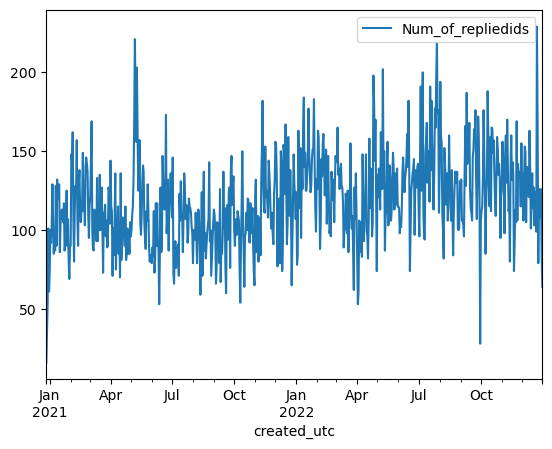

In [63]:
lines = comment_s.plot.line(y='Num_of_repliedids')

<AxesSubplot:xlabel='created_utc'>

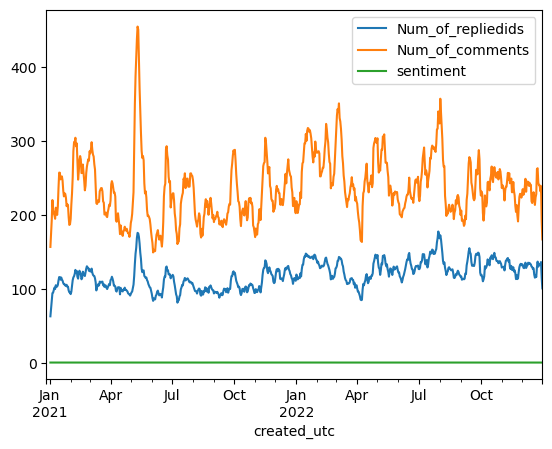

In [64]:
ma.plot()

<AxesSubplot:xlabel='created_utc'>

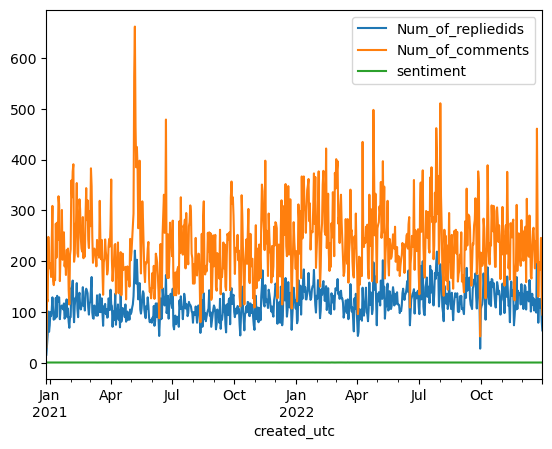

In [65]:
comment_s.plot()

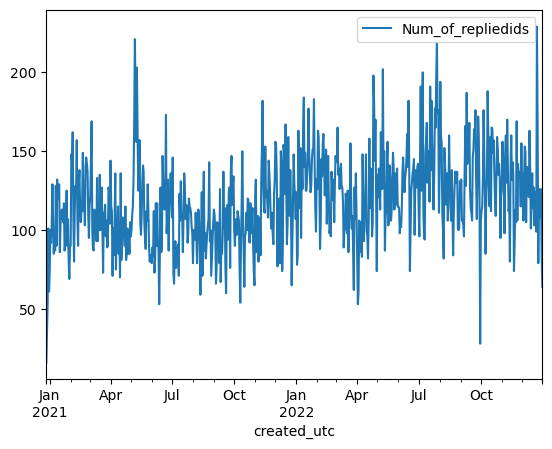

In [66]:
comment_s.plot(y = 'Num_of_repliedids')
plt.show()

In [68]:
comment.shape

(173867, 13)

In [69]:
comment.head()

,created_utc,commentID,link,is_submitter,author,author_flair_richtext,link_id,parent_id,score,body,is_submitier,post_id,sentiment
0,2021-12-31,hqrvdz6,https://www.reddit.com/r/work/comments/rsrfa3/...,,Additional_Repeat_12,[],t3_rsrfa3,None,2,work salary answer call time work life balanc...,False,rsrfa3,0.999954
1,2021-12-31,hqrupnz,https://www.reddit.com/r/work/comments/rtaumo/...,,X-Bones_21,[],t3_rtaumo,38623883497,3,second sort ups rarely interact coworker go...,False,rtaumo,1.000000
2,2021-12-31,hqrtx88,https://www.reddit.com/r/work/comments/rtaumo/...,,getfuckedhoayoucunts,[],t3_rtaumo,None,-3,ceo \n\n usless fuck sit piss arse listen \n\...,False,rtaumo,0.004856
3,2021-12-31,hqrs9pw,https://www.reddit.com/r/work/comments/rtaumo/...,,[deleted],,t3_rtaumo,None,1,account,False,rtaumo,0.674719
4,2021-12-31,hqrrz2c,https://www.reddit.com/r/work/comments/rsp1vx/...,,PristineAd9800,[],t3_rsp1vx,None,2,work happen cuz maybe thing got heat cuz say...,False,rsp1vx,0.868883


In [74]:
event = comment[comment['created_utc']=='2021-06-07']

In [76]:
event.shape

(215, 13)

In [79]:
max_features = 3000
maxlen = 80  # cut texts after this number of words (among top max_features most common words)
batch_size = 32
tokenizer1 = Tokenizer(num_words=max_features, split=' ')
tokenizer1.fit_on_texts(event['body'].values)

In [80]:
tokenizer1.word_index

{'work': 1,
 'job': 2,
 'want': 3,
 'like': 4,
 'time': 5,
 'good': 6,
 'company': 7,
 'people': 8,
 'thing': 9,
 'know': 10,
 'go': 11,
 'day': 12,
 'think': 13,
 'feel': 14,
 'need': 15,
 'look': 16,
 'pay': 17,
 'thank': 18,
 'tell': 19,
 'say': 20,
 'find': 21,
 'leave': 22,
 'get': 23,
 'hour': 24,
 'boss': 25,
 'r': 26,
 'new': 27,
 'well': 28,
 'sure': 29,
 'labour': 30,
 'employee': 31,
 'right': 32,
 'way': 33,
 'issue': 34,
 'long': 35,
 'month': 36,
 'lot': 37,
 'luck': 38,
 'ask': 39,
 'uk': 40,
 'actually': 41,
 'year': 42,
 'reason': 43,
 'employer': 44,
 'question': 45,
 'state': 46,
 'place': 47,
 'try': 48,
 'break': 49,
 'contract': 50,
 'manager': 51,
 'take': 52,
 'offer': 53,
 'client': 54,
 'talk': 55,
 'support': 56,
 'office': 57,
 'term': 58,
 'policy': 59,
 'benefit': 60,
 'come': 61,
 'hard': 62,
 'week': 63,
 'away': 64,
 'short': 65,
 'clause': 66,
 'give': 67,
 'law': 68,
 'wage': 69,
 'affect': 70,
 'account': 71,
 'coworker': 72,
 'yes': 73,
 'quit': 74,